In [1]:
import tensorflow as tf
from tensorflow import keras

import IPython # interactive shell built with Python

In [2]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 4.6MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=bc3c38969e77b21153a372a0647ecfb9eb3eb592fa55f531c924af09e869e995
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=379279afa03cd30d4075538b12fdc180321aec4e332788844716d764556cec11
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [3]:
import kerastuner as kt

In [4]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
img_train = img_train.astype('float32') / 255.0
imt_test = img_test.astype('float32') / 255.0

In [6]:
len(img_train), len(img_test)

(60000, 10000)

In [7]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))

    # choose an optimal value between 32 and 512
    hp_unit = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_unit, activation='relu'))
    model.add(keras.layers.Dense(10))

    # choose an optimal value
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return model

In [8]:
# Hyperband: one of the hyper tuners
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 10,
                     factor = 3, # use to determine the number of models to train
                     directory = 'my_dir',
                     project_name = 'theFirstKT')

In [9]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait=True)

In [10]:
tuner.search(img_train, label_train, epochs=10, validation_data=(img_test,label_test), callbacks=[ClearTrainingOutput()])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 41s]
val_accuracy: 0.8766999840736389

Best val_accuracy So Far: 0.8766999840736389
Total elapsed time: 00h 09m 04s
INFO:tensorflow:Oracle triggered exit


In [11]:
best_hps

In [12]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 320)               251200    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3210      
Total params: 254,410
Trainable params: 254,410
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(img_train, label_train, epochs=10, validation_data=(img_test, label_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4805 - accuracy: 0.8304 - val_loss: 61.5607 - val_accuracy: 0.8404
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3653 - accuracy: 0.8664 - val_loss: 58.5069 - val_accuracy: 0.8504
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3219 - accuracy: 0.8811 - val_loss: 49.0592 - val_accuracy: 0.8599
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3012 - accuracy: 0.8892 - val_loss: 59.3230 - val_accuracy: 0.8544
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2814 - accuracy: 0.8959 - val_loss: 48.5463 - val_accuracy: 0.8782
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2659 - accuracy: 0.9009 - val_loss: 48.5810 - val_accuracy: 0.8710
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2531 - accuracy: 0.9049 - val_loss: 57.6115 - val_ac

In [14]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

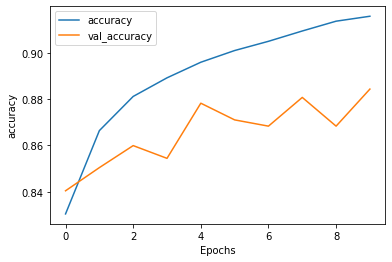

In [15]:
plot_graphs(history, 'accuracy')

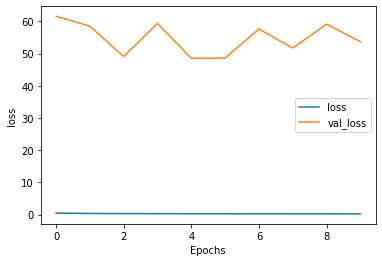

In [16]:
plot_graphs(history, 'loss')